In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"


import numpy as np

# Load pre-extracted features
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [2]:
# %%
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Use the same transform as before (just for consistency, although it's not used here)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Reload the train dataset to get class names
train_data = ImageFolder(root="../fruits train", transform=transform)
class_names = train_data.classes  # e.g., ['Bananas plant', 'Durian plant', ...]
class_to_idx = train_data.class_to_idx  # e.g., {'Bananas plant': 0, 'Durian plant': 1, ...}
idx_to_class = {v: k for k, v in class_to_idx.items()}


In [3]:
print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Classes:", np.unique(y_train))

Training shape: (1615, 512)
Test shape: (404, 512)
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize model
knn = KNeighborsClassifier()

# GridSearchCV
grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=1
)

In [5]:
# Train model with grid search
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/Caskroom/miniconda/base/envs/py310/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.8148606811145511


In [6]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load your data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Run grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=1)
grid_search.fit(X_train, y_train)

# Get top 3 configs by CV accuracy
cv_results = pd.DataFrame(grid_search.cv_results_)
top3 = cv_results.sort_values(by='mean_test_score', ascending=False).head(3)

# Compute full metrics on test set for top 3
rows = []
for _, row in top3.iterrows():
    params = row['params']
    model = KNeighborsClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rows.append([
        str(params),
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='macro'),
        recall_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='macro'),
    ])



Fitting 5 folds for each of 16 candidates, totalling 80 fits


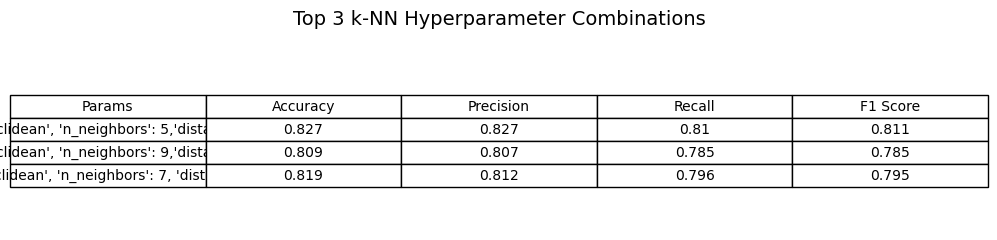

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Your DataFrame (already rounded to 3 sigfigs)
metrics_df = pd.DataFrame([
    ["{'euclidean', 'n_neighbors': 5,'distance'}", 0.827, 0.827, 0.810, 0.811],
    ["{'euclidean', 'n_neighbors': 9,'distance'}", 0.809, 0.807, 0.785, 0.785],
    ["{'euclidean', 'n_neighbors': 7, 'distance'}", 0.819, 0.812, 0.796, 0.795]
], columns=["Params", "Accuracy", "Precision", "Recall", "F1 Score"])

# Plot the table
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.axis('off')  # Turn off the axes

# Create the table
table = ax.table(cellText=metrics_df.values,
                 colLabels=metrics_df.columns,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Title
plt.title("Top 3 k-NN Hyperparameter Combinations", fontsize=14, pad=20)

# Save and show
plt.tight_layout()
plt.savefig("knn_metrics_cleaned.png", dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# Evaluate on test set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

class_names = train_data.classes


# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Test Accuracy: 0.8267326732673267
Classification Report:
                              precision    recall  f1-score   support

               Bananas plant       0.95      0.84      0.89        43
                Durian plant       0.93      0.93      0.93        28
Eggplants (Aubergines) plant       0.90      0.82      0.86        33
                Garlic plant       0.93      0.62      0.74        21
                Ginger plant       0.62      0.42      0.50        12
                Grapes plant       0.78      0.81      0.79        26
  Groundnuts (Peanuts) plant       1.00      0.90      0.95        20
      Lemons and limes plant       0.97      0.85      0.90        33
                Lychee plant       0.85      0.85      0.85        27
               Oranges plant       0.72      0.90      0.80        20
Peaches and nectarines plant       0.84      0.94      0.89        33
           Raspberries plant       0.78      0.78      0.78        27
             Scallions plant    

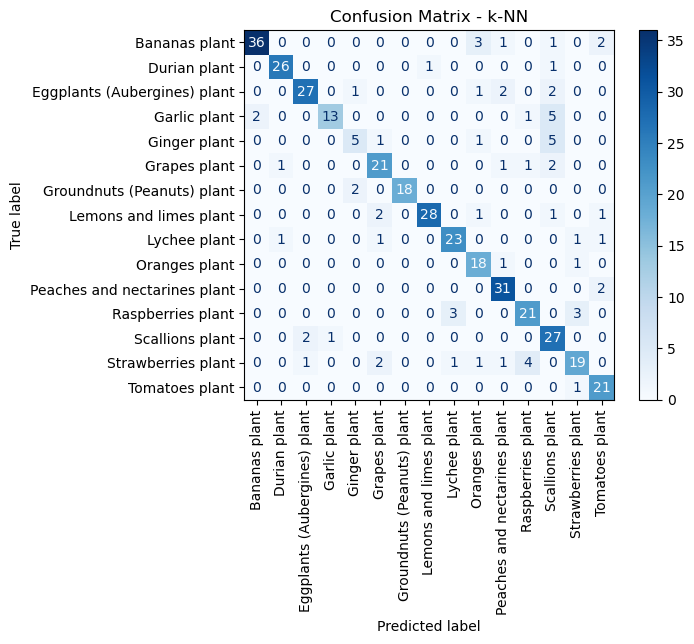

In [9]:
# Optional: Save the best model
import joblib
joblib.dump(best_knn, 'best_knn_model.pkl')

# Optional: Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


ConfusionMatrixDisplay.from_estimator(
    best_knn,
    X_test,
    y_test,
    display_labels=class_names,  # <-- class names here
    cmap='Blues',
    xticks_rotation=90  # optional: tilt x-axis labels for readability
)

plt.title("Confusion Matrix - k-NN")
plt.savefig('knn_confusion_matrix.png', bbox_inches='tight')
plt.show()
